# 3. Pregunta de Investigación 2: ¿El resultado al descanso determina el resultado final?

Usaremos un test de independencia **Chi-Cuadrado ($\chi^2$)** para ver si existe una dependencia estadística fuerte entre cómo termina el primer tiempo y cómo termina el partido.

**Variables a utilizar:**
*   `HTR` (Half Time Result): Resultado al medio tiempo (H=Local, D=Empate, A=Visitante).
*   `FTR` (Full Time Result): Resultado al final del partido.

Esta prueba no compara promedios, sino frecuencias en una **Tabla de Contingencia**.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Cargar el dataset limpio
df = pd.read_csv('../data/cleaned_dataset.csv')

# Previsualizar las variables de interés
# Filtramos solo las columnas de resultados para ver su estructura


In [12]:
df_resultados = df[['HTR', 'FTR']].dropna()

print("Primeras 5 filas de nuestros datos:")
print(df_resultados.head())

print("\nConteo de situaciones al descanso:")
print(df_resultados['HTR'].value_counts())

Primeras 5 filas de nuestros datos:
  HTR FTR
0   H   H
1   H   H
2   D   A
3   A   D
4   H   H

Conteo de situaciones al descanso:
HTR
D    2853
H    2415
A    1572
Name: count, dtype: int64


## 1. Tabla de Contingencia y Visualización

El primer paso es cruzar los datos. Crearemos una matriz donde las **Filas** representan cómo iban al descanso y las **Columnas** cómo terminaron.
-   **Diagonal Princip:** Casos donde el resultado se mantuvo (ej. Ganaba Local -> Ganó Local).
-   **Fuera de la Diagonal:** Casos donde hubo remontada o cambio de guion.

FTR,H,D,A
HTR,,,
H,1961,330,124
D,1061,1085,707
A,154,336,1082


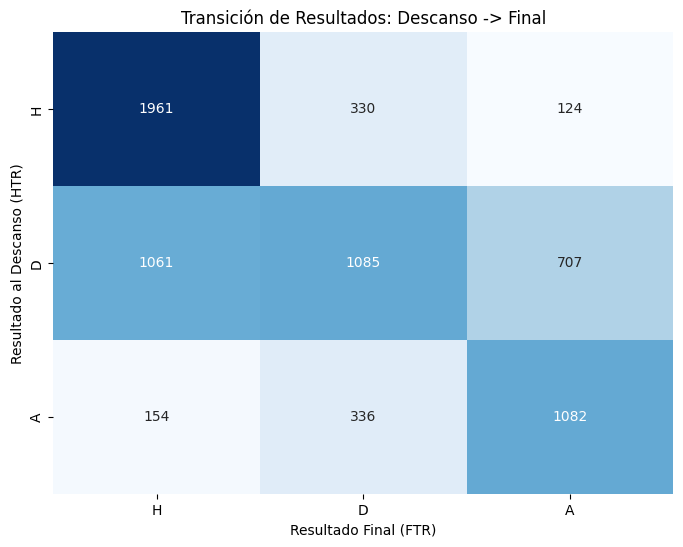

In [13]:
# Definir el orden para que sea intuitivo: Local -> Empate -> Visitante
orden = ['H', 'D', 'A']

# Crear la tabla cruzada (Crosstab)
tabla_contingencia = pd.crosstab(
    df_resultados['HTR'], # Filas: Medio Tiempo
    df_resultados['FTR']  # Columnas: Final
).reindex(index=orden, columns=orden)

display(tabla_contingencia)

# Visualizar con un Mapa de Calor
plt.figure(figsize=(8, 6))
sns.heatmap(tabla_contingencia, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Transición de Resultados: Descanso -> Final')
plt.xlabel('Resultado Final (FTR)')
plt.ylabel('Resultado al Descanso (HTR)')
plt.show()

## 2. Prueba de Hipótesis (Chi-Cuadrado)

Evaluaremos si existe una relación estadísticamente significativa entre el resultado al descanso y el final.

**Hipótesis:**
*   $H_0$ (Nula): El resultado al descanso y el final son **Independientes** (lo que pasa en el 1er tiempo no influye en el resultado final).
*   $H_1$ (Alternativa): El resultado al descanso y el final son **Dependientes** (están relacionados).

Usaremos la función `chi2_contingency` para calcular el P-Value.

In [14]:
from scipy.stats import chi2_contingency

# Ejecutar el test de Chi-Cuadrado de Independencia
chi2, p_value, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Estadístico Chi-Cuadrado: {chi2:.2f}")
print(f"P-Value: {p_value:.30f}") # Usamos formato decimal largo porque será un número muy cercano a cero

print("\n--- Conclusión ---")
if p_value < 0.05:
    print("Rechazamos la Hipótesis Nula.")
    print("Existe una DEPENDENCIA ESTADÍSTICAMENTE SIGNIFICATIVA.")
    print("El resultado al descanso predice fuertemente el resultado final.")
else:
    print("No podemos rechazar la Hipótesis Nula (Son independientes).")

Estadístico Chi-Cuadrado: 2852.21
P-Value: 0.000000000000000000000000000000

--- Conclusión ---
Rechazamos la Hipótesis Nula.
Existe una DEPENDENCIA ESTADÍSTICAMENTE SIGNIFICATIVA.
El resultado al descanso predice fuertemente el resultado final.


## 3. Probabilidades Condicionales (Interpretación)

El P-Value nos dice que **hay relación**, pero no nos dice **cómo es**.
Calcularemos la probabilidad de cada resultado final dado un resultado al descanso.
**Pregunta clave:** Si un equipo va ganando al descanso, ¿qué probabilidad tiene de mantener la victoria?

FTR,H,D,A
HTR,,,
H,81.20,13.66,5.13
D,37.19,38.03,24.78
A,9.80,21.37,68.83


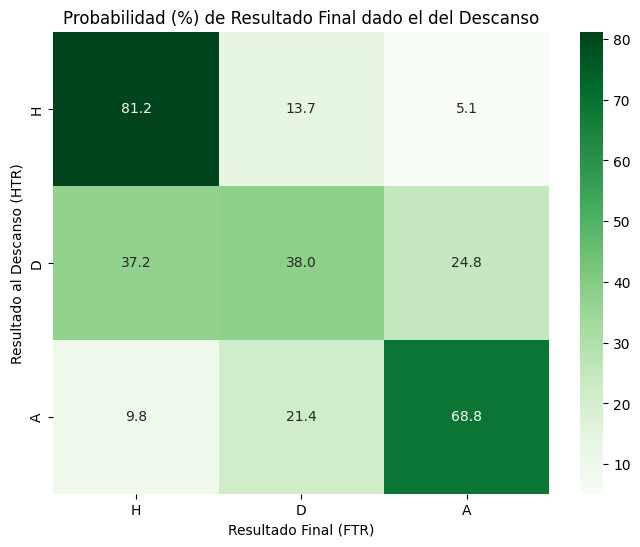

Si el Local gana al descanso, tiene un 81.2% de probabilidad de ganar el partido.
Si el Visitante gana al descanso, tiene un 68.8% de probabilidad de ganar el partido.


In [15]:
# Calcular porcentajes por fila (normalizar sobre index)
# div(..., axis=0) divide cada valor por la suma de su fila
probs_transicion = tabla_contingencia.div(tabla_contingencia.sum(axis=1), axis=0) * 100

display(probs_transicion.round(2))

# Visualizar Probabilidades
plt.figure(figsize=(8, 6))
sns.heatmap(probs_transicion, annot=True, fmt='.1f', cmap='Greens', cbar=True)
plt.title('Probabilidad (%) de Resultado Final dado el del Descanso')
plt.xlabel('Resultado Final (FTR)')
plt.ylabel('Resultado al Descanso (HTR)')
plt.show()

# Ejemplo de interpretación automática
prob_h_h = probs_transicion.loc['H', 'H']
prob_a_a = probs_transicion.loc['A', 'A']
print(f"Si el Local gana al descanso, tiene un {prob_h_h:.1f}% de probabilidad de ganar el partido.")
print(f"Si el Visitante gana al descanso, tiene un {prob_a_a:.1f}% de probabilidad de ganar el partido.")